In [1]:
import os, shutil
import flopy as fp
import numpy as np
import pyemu
import pandas as pd
import matplotlib.pyplot as plt
import pestools as pt
%matplotlib inline
# Quick check for Windows to make sure input files are Windows type
import platform
if 'window' in platform.platform().lower():
    ppp = 'pest++'
    newln='\n'
else:
    ppp='pestpp'
    newln='\r\n'
    
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MultipleLocator


setting random seed


### Let's load up a couple arrays we will need for visualizing results

In [2]:
base_dir = os.path.join('..','..','models','Freyberg','Freyberg_pilotpoints')
[shutil.copy2(os.path.join(base_dir,cf),cf) for cf in os.listdir(base_dir)];
if not os.path.exists('base_pp_dir'):
    os.mkdir('base_pp_dir')
[shutil.copy2(os.path.join(base_dir,cf),os.path.join('base_pp_dir',cf)) for cf in os.listdir(base_dir)];


In [8]:
# Since this is a sythetic example, we can load up the true K field to compare our answers to 
HK_truth = np.loadtxt(os.path.join('..','..','models','Freyberg','Freyberg_Truth','hk.truth.ref'))
# ibound can be used to mask inactive areas
ib = np.loadtxt('ibound.ref')
HK_truth[ib==0] = np.nan
forecasts_true = pd.read_csv(os.path.join('..','..','models','Freyberg','Freyberg_Truth','forecasts_true.csv'), index_col=0)

In [9]:
forecasts_true

,true_mean
name,
FR03C16,19.58638
FR04C9,22.53065
RIVFLUX_FORE,-2685.39400
TRAVEL_TIME,40501.81000


# Set up a couple functions to help with displaying results

In [4]:
def update_K(inpstname):
    optpst = pyemu.Pst(inpstname + '.pst')
    # reset the parameter values using the best parameters from the last run
    optpst.parrep(inpstname + '.bpa')
    # set NOPTMAX=0 to run the model just a single time
    optpst.control_data.noptmax=0
    # write out the PST file with a new name
    optpst.write(inpstname + '_opt.pst')
    # run the new version of the model
    os.system('{0} {1}_opt.pst'.format(ppp, inpstname))

In [5]:
def plot_K_results(inpstname):
    HK_best = np.loadtxt('hk.ref')
    HK_best[ib==0] = np.nan
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(8,4))
    im1=ax1.imshow(HK_truth, interpolation='nearest', cmap='viridis', vmin = np.nanmin(HK_truth), vmax = np.nanmax(HK_truth))
    divider1 = make_axes_locatable(ax1)
    cax1 = divider1.append_axes("right", size="20%", pad=0.05)
    cbar1 = plt.colorbar(im1, cax=cax1,format="%.2f")

    im2=ax2.imshow(HK_best, interpolation='nearest', cmap='viridis', vmin = np.nanmin(HK_truth), vmax = np.nanmax(HK_truth))
    divider2 = make_axes_locatable(ax2)
    cax2 = divider2.append_axes("right", size="20%", pad=0.05)
    cbar2 = plt.colorbar(im2, cax=cax2,  format="%.2f")

    im3=ax3.imshow(HK_best, interpolation='nearest', cmap='viridis')
    divider3 = make_axes_locatable(ax3)
    cax3 = divider3.append_axes("right", size="20%", pad=0.05)
    cbar3 = plt.colorbar(im3, cax=cax3,  format="%.2f")
    plt.tight_layout()
    plt.savefig(inpstname + 'HK_.pdf')
    
    plt.figure()
    inphi = pd.read_csv(inpstname +'.iobj')
    inphi[['total_phi','measurement_phi', 'regularization_phi']].plot()
    plt.gca().set_yscale('log')
    plt.ylabel('PHI')
    plt.xlabel('Iteration Number')

In [15]:
def see_residuals(inpstname):
    res = pt.Res(inpstname + '.rei')
    print("HEAD FIT")
    print(res.describe_groups('head_cal'))
    print("FLUX FIT")
    print(res.describe_groups('flux_cal'))
    res.plot_one2one('head_cal',print_stats=['Mean', 'MAE', 'RMSE'])
    df_predu = pd.read_csv(inpstname + ".pred.usum.csv",index_col=0)
    df_predu = df_predu.join(forecasts_true)
    for forecast in df_predu.index:
        plt.figure()
        ax = df_predu.loc[forecast,["prior_mean","post_mean","true_mean"]].plot(kind="bar")
        ax.set_title(forecast)

# Pilot Points with Regularization controlled by `PHIMLIM`
There are a couple ways to control regularization in `pest++`. First we will cover using the variable `phimlim`

## First we can run without regularization (e.g. `PHIMLIM` is very low)

In [7]:
pyemu.utils.start_slaves('base_pp_dir',"{0}".format(ppp),"freyberg_pp_reg.pst",20,slave_root='.',port=4004,master_dir='.')

HEAD FIT
                     Group summary
n                               13
Range                       1.3475
Max                        0.66146
Min                       -0.68604
Mean                    -0.0158362
Standard deviation        0.280278
Varience                 0.0785555
25%                       -0.00049
50%                        0.00048
75%                        0.00169
Max (absolute)             0.68604
Min (absolute)               1e-05
MAE                        0.12355
RMSE                      0.269747
RMSE/range                0.200183
Normally Distributed          True
p-value                0.000385381
FLUX FIT
                      Group summary
n                          1.000000
Range                      0.000000
Max                       -0.978000
Min                       -0.978000
Mean                      -0.978000
Standard deviation              NaN
Varience                        NaN
25%                       -0.978000
50%                       -0

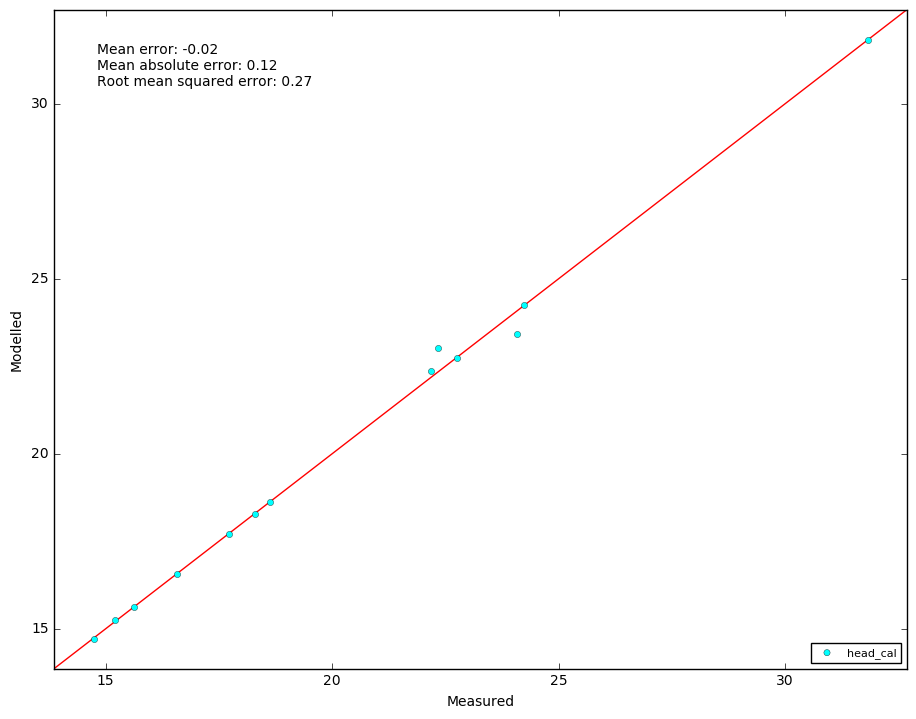

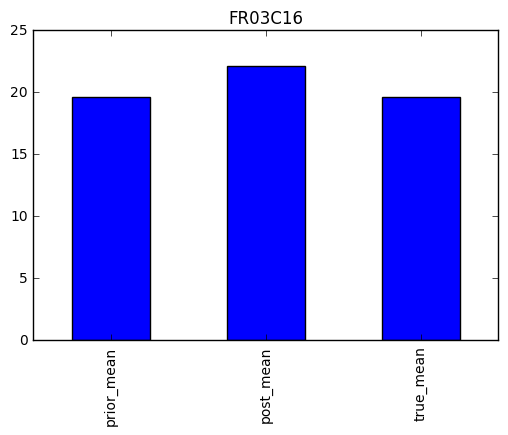

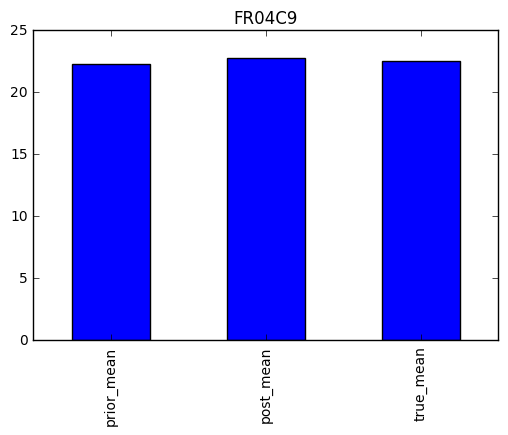

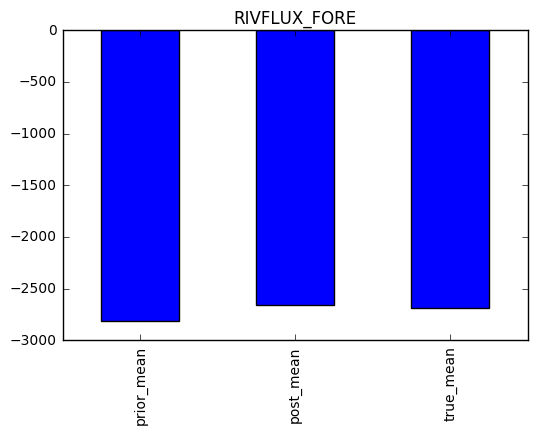

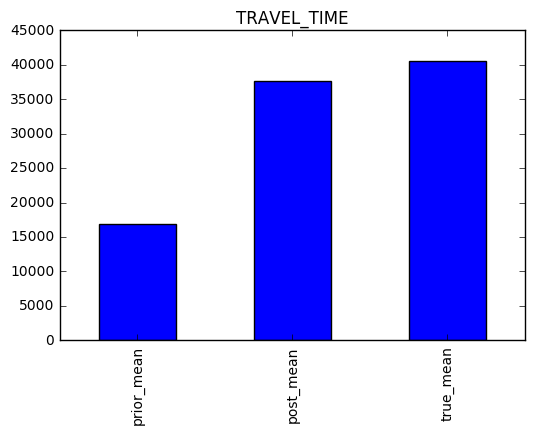

In [16]:
see_residuals('freyberg_pp_reg')

In [9]:
update_K('freyberg_pp_reg')

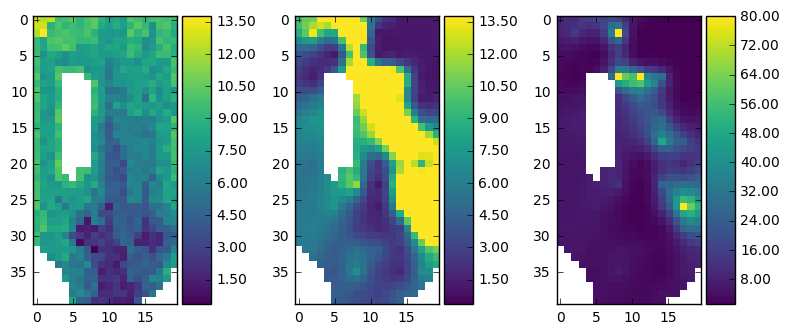

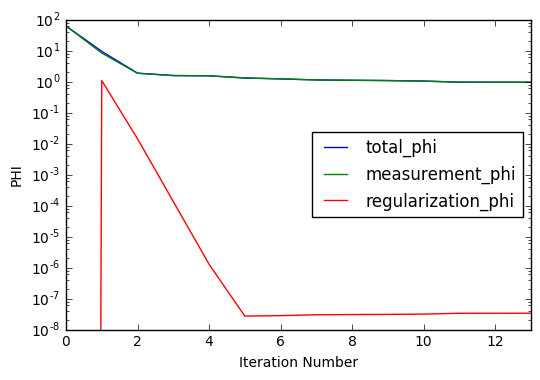

In [10]:
plot_K_results('freyberg_pp_reg')

In [20]:
inpst = pyemu.Pst('freyberg_pp_reg.pst')
inpst.regul_lines

['   2.500000e-05       2.625000e-05     0.1000000\n',
 '   1.0000      1.00000E-10  1.00000E+10\n',
 '   1.3 1.0e-2  1\n']

### Let's increase `PHIMLIM` to 50

In [21]:
inpst.regul_lines[0] = ' 5.0e+01  5.25e+01 0.1 \n'
inpst.regul_lines


[' 5.0e+01  5.25e+01 0.1 \n',
 '   1.0000      1.00000E-10  1.00000E+10\n',
 '   1.3 1.0e-2  1\n']

In [22]:
phimlim50 = 'freyberg_pp_reg_phimlim50'
inpst.write('{0}.pst'.format(phimlim50))
shutil.copy2('{0}.pst'.format(phimlim50), os.path.join('base_pp_dir','{0}.pst'.format(phimlim50)))

'base_pp_dir/freyberg_pp_reg_phimlim50.pst'

In [14]:
pyemu.utils.start_slaves('base_pp_dir',"{0}".format(ppp),'{0}.pst'.format(phimlim50),20,slave_root='.',port=4004,master_dir='.')

HEAD FIT
                     Group summary
n                               13
Range                      4.25725
Max                        3.54046
Min                       -0.71679
Mean                       1.33657
Standard deviation         1.50019
Varience                   2.25057
25%                       -0.33622
50%                         1.4399
75%                         2.5119
Max (absolute)             3.54046
Min (absolute)             0.33622
MAE                        1.63349
RMSE                       1.96567
RMSE/range                0.461723
Normally Distributed         False
p-value                   0.267535
FLUX FIT
                      Group summary
n                          1.000000
Range                      0.000000
Max                      132.649000
Min                      132.649000
Mean                     132.649000
Standard deviation              NaN
Varience                        NaN
25%                      132.649000
50%                      132

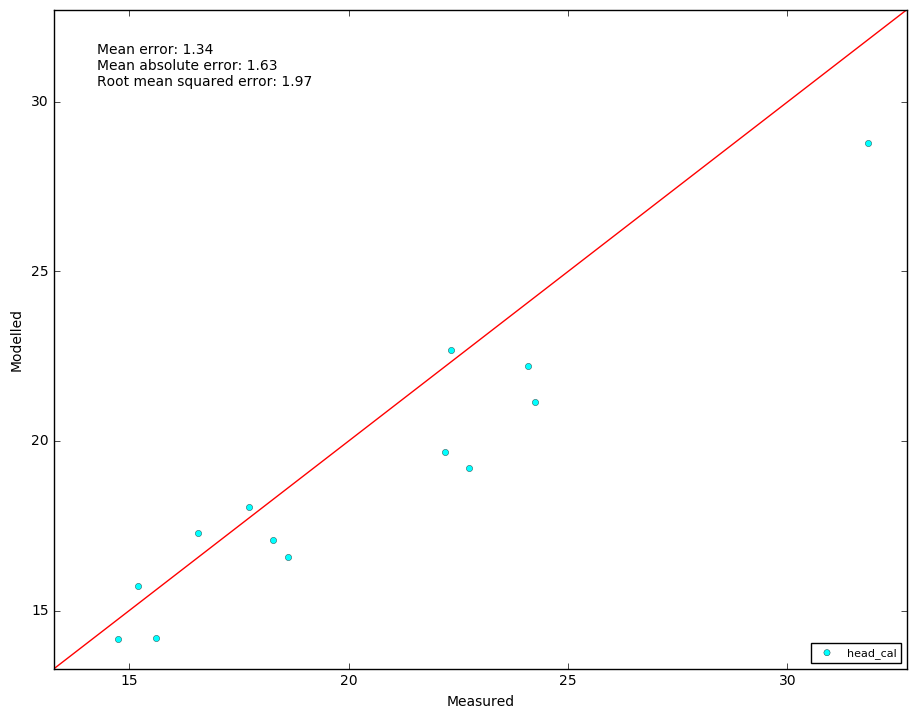

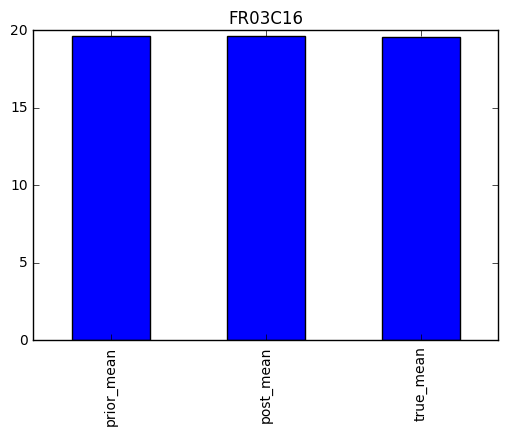

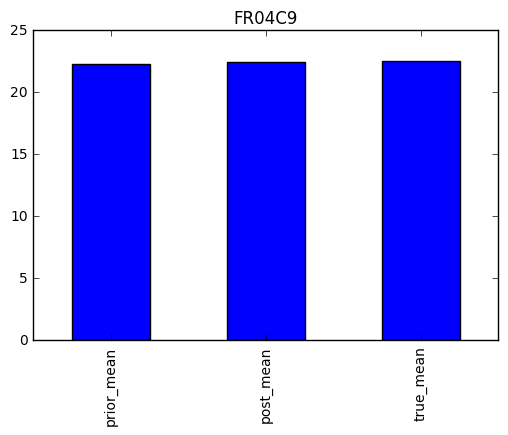

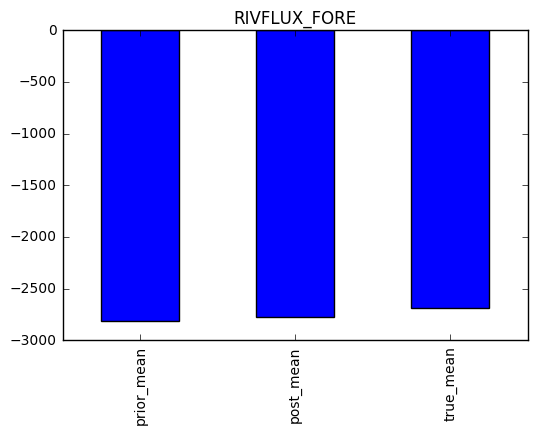

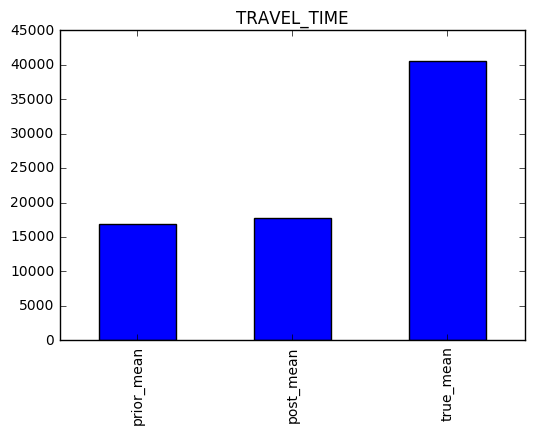

In [23]:
see_residuals(phimlim50)

In [16]:
update_K(phimlim50)

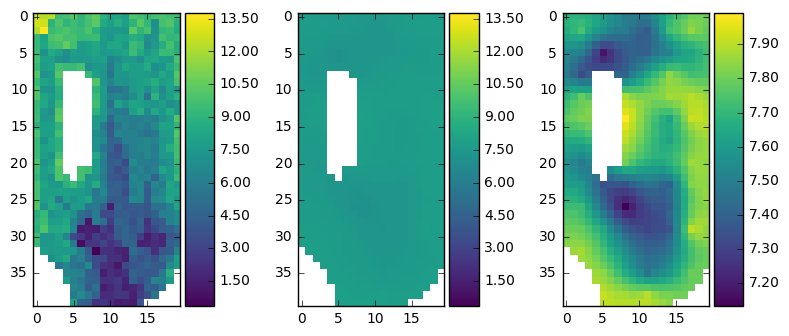

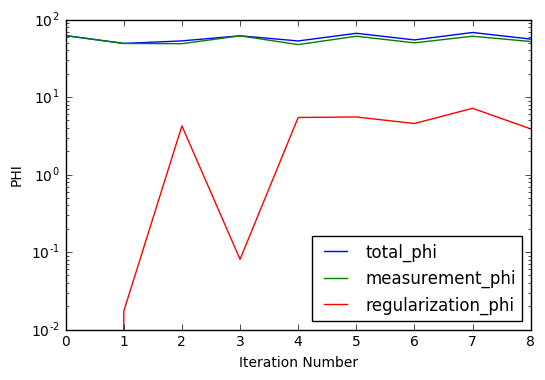

In [17]:
plot_K_results(phimlim50)

### `PHIMLIM=14` is another choice

In [24]:
inpst = pyemu.Pst('freyberg_pp_reg.pst')
inpst.regul_lines

['   2.500000e-05       2.625000e-05     0.1000000\n',
 '   1.0000      1.00000E-10  1.00000E+10\n',
 '   1.3 1.0e-2  1\n']

In [25]:
inpst.regul_lines[0] = ' 14.0 14.7 0.1 \n'
inpst.regul_lines

[' 14.0 14.7 0.1 \n',
 '   1.0000      1.00000E-10  1.00000E+10\n',
 '   1.3 1.0e-2  1\n']

In [26]:
phimlim14 = 'freyberg_pp_reg_phimlim14'
inpst.write('{0}.pst'.format(phimlim14))
shutil.copy2('{0}.pst'.format(phimlim14), os.path.join('base_pp_dir','{0}.pst'.format(phimlim14)))

'base_pp_dir/freyberg_pp_reg_phimlim14.pst'

In [21]:
pyemu.utils.start_slaves('base_pp_dir',"{0}".format(ppp),'{0}.pst'.format(phimlim14),20,slave_root='.',port=4004,master_dir='.')

HEAD FIT
                     Group summary
n                               13
Range                      3.67255
Max                        2.40029
Min                       -1.27226
Mean                      0.329949
Standard deviation         1.00634
Varience                   1.01272
25%                       -0.58141
50%                        0.38269
75%                        0.99643
Max (absolute)             2.40029
Min (absolute)             0.19759
MAE                       0.861691
RMSE                       1.02161
RMSE/range                0.278175
Normally Distributed         False
p-value                   0.719479
FLUX FIT
                      Group summary
n                          1.000000
Range                      0.000000
Max                       33.608000
Min                       33.608000
Mean                      33.608000
Standard deviation              NaN
Varience                        NaN
25%                       33.608000
50%                       33

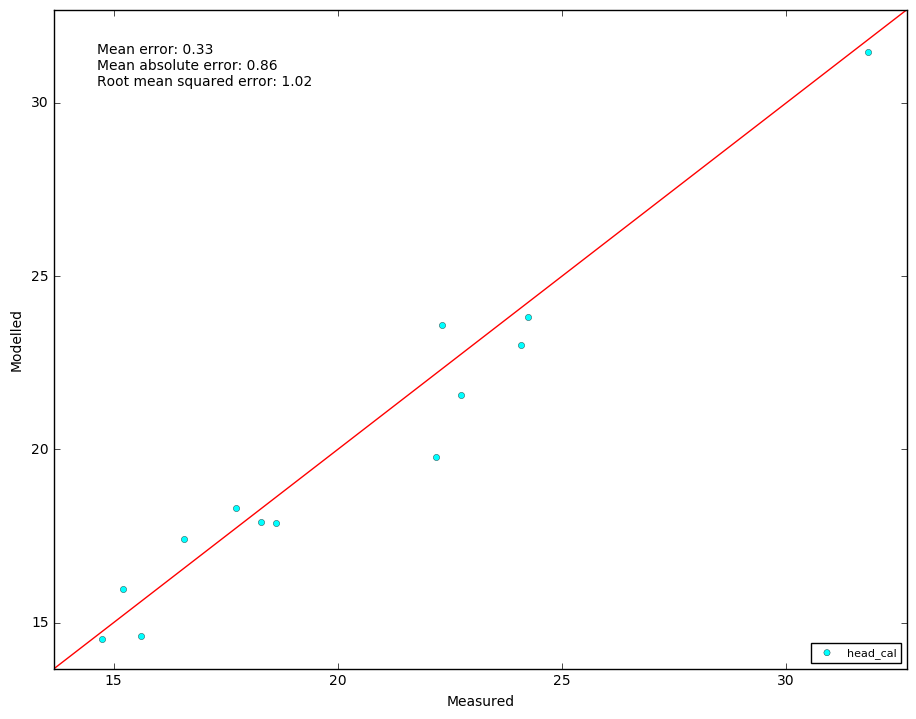

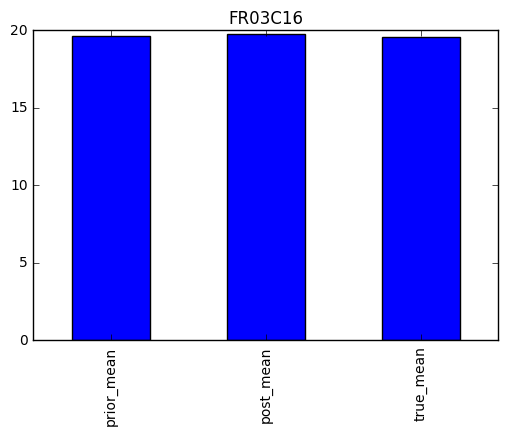

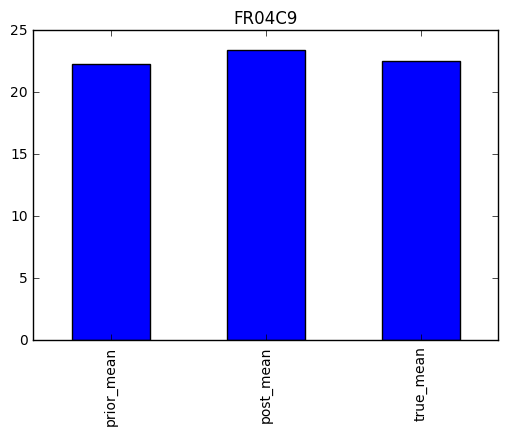

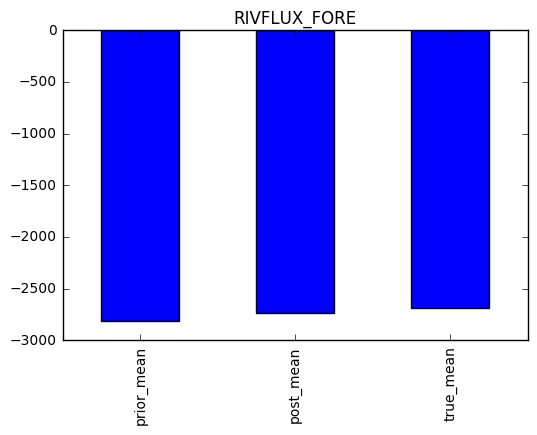

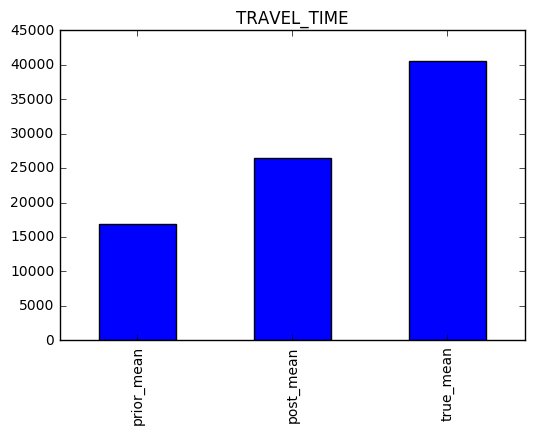

In [27]:
see_residuals(phimlim14)

In [23]:
update_K(phimlim14)

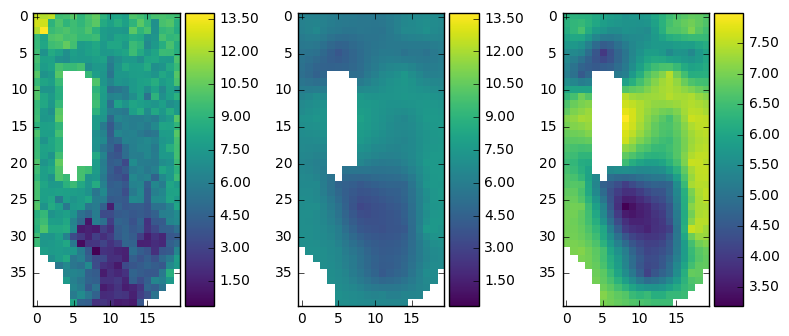

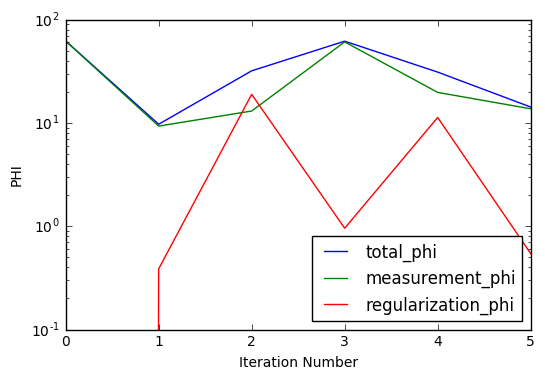

In [24]:
plot_K_results(phimlim14)

### Finally, how about `PHIMLIM=26`?

In [28]:
inpst = pyemu.Pst('freyberg_pp_reg.pst')
inpst.regul_lines

['   2.500000e-05       2.625000e-05     0.1000000\n',
 '   1.0000      1.00000E-10  1.00000E+10\n',
 '   1.3 1.0e-2  1\n']

In [29]:
inpst.regul_lines[0] = ' 26.0 27.5 0.1\n'
inpst.regul_lines

[' 26.0 27.5 0.1\n',
 '   1.0000      1.00000E-10  1.00000E+10\n',
 '   1.3 1.0e-2  1\n']

In [30]:
phimlim26 = 'freyberg_pp_reg_phimlim26'
inpst.write('{0}.pst'.format(phimlim26))
shutil.copy2('{0}.pst'.format(phimlim26), os.path.join('base_pp_dir','{0}.pst'.format(phimlim26)))

'base_pp_dir/freyberg_pp_reg_phimlim26.pst'

In [12]:
pyemu.utils.start_slaves('base_pp_dir',"{0}".format(ppp),'{0}.pst'.format(phimlim26),20,slave_root='.',port=4004,master_dir='.')

HEAD FIT
                     Group summary
n                               13
Range                      3.44786
Max                        2.46351
Min                       -0.98435
Mean                      0.811979
Standard deviation         1.21004
Varience                    1.4642
25%                       -0.48447
50%                        1.25793
75%                        1.48863
Max (absolute)             2.46351
Min (absolute)             0.39385
MAE                        1.25982
RMSE                       1.41806
RMSE/range                0.411286
Normally Distributed         False
p-value                   0.197035
FLUX FIT
                      Group summary
n                          1.000000
Range                      0.000000
Max                       92.999000
Min                       92.999000
Mean                      92.999000
Standard deviation              NaN
Varience                        NaN
25%                       92.999000
50%                       92

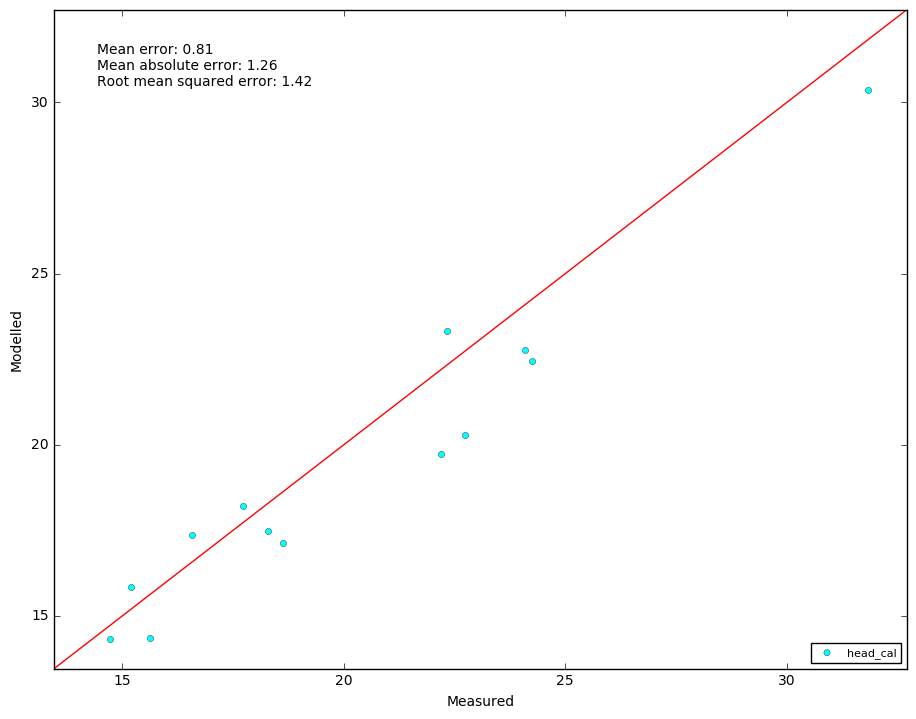

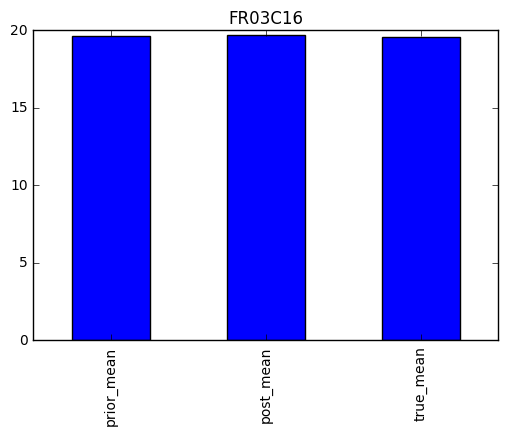

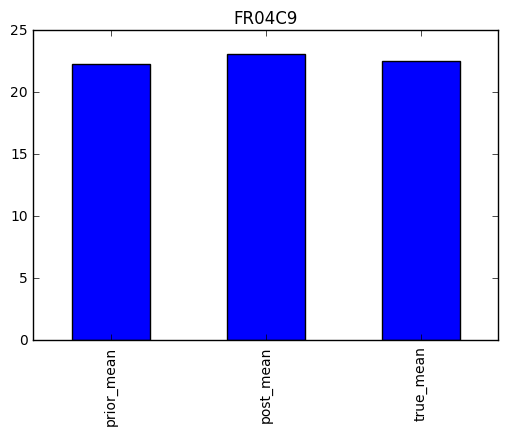

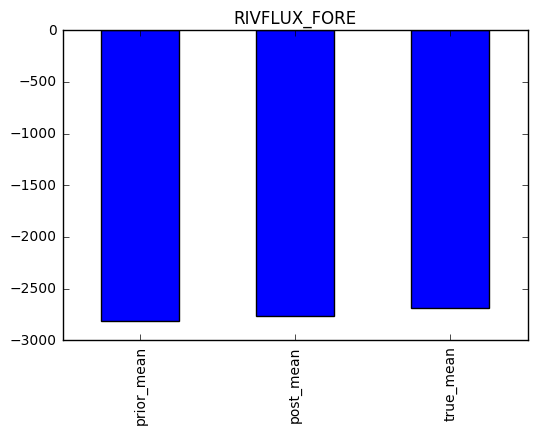

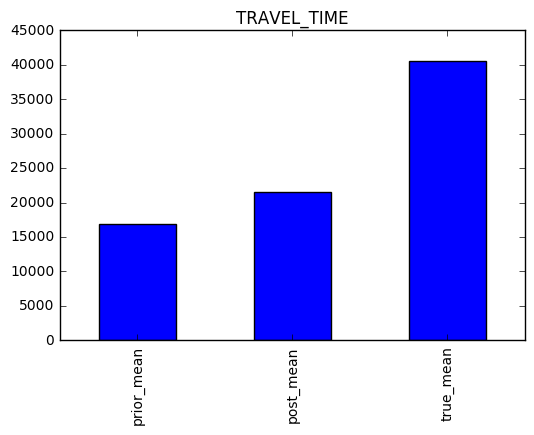

In [31]:
see_residuals(phimlim26)

In [30]:
update_K(phimlim26)

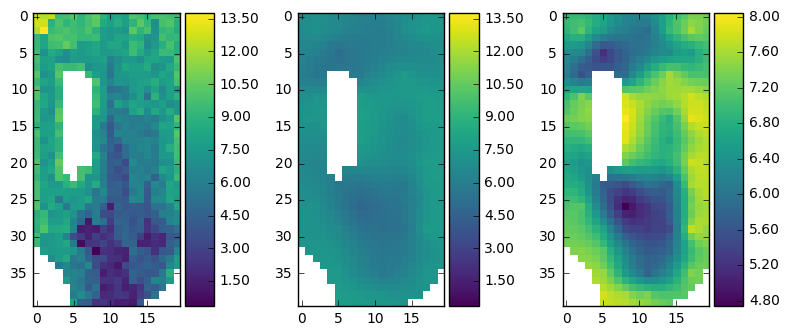

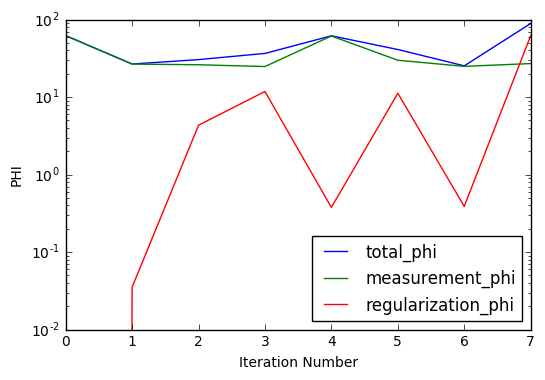

In [31]:
plot_K_results(phimlim26)